# Module 2: Water flow in soil (steady state) 

*by Daniel Leitner, Andrea Schnepf, Valentin Couvreur, Axelle Koch*

## Theory


Water flow in soil is described by the Richards equation, which is given by 
\begin{eqnarray} \label{eq:rich1d}
\frac{\partial \theta}{\partial t}=  \nabla \cdot\left( K_c(\theta) \left( \nabla \psi_s - e_3 \right) \right),
\end{eqnarray}
in three dimesnions, where $\theta$ is the water content [1], $K_c$ is the hydraulic conductivity [cm / day], and  $\psi_s$ is the soil matric potential [cm]. 


The relationship between soil water potential and water content is generally described by the water retention curve. In the following we will use the Mualem Van Genuchten model (Van Genuchten, 1980) to describe this curve specifying the soil moisture characteristic of specific soils. 

## Benchmarks


Benchmarks for water movement in soil were developed by Vanderborght et al. (2005). In the following we will shortly describe the steady state benchmarks and their analytical solutions. The derivation is given by Vanderborght et al. (2005).  

In the following benchmarks soil properties are described by the van Genuchten model (Van Genuchten, 1980). In the following we first import libraries and define some auxiliary functions:

In [41]:
import numpy as np
from scipy import optimize
from scipy import integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from math import * 
import os
import ast

In [42]:
# Mualem - van Genuchten model, equations from van Genuchten, MT (1980)

# class containing the van genuchten parameters
class Parameters:
    def __init__(self, R, S, alpha, n, Ksat):
        self.theta_R = R
        self.theta_S = S        
        self.alpha = alpha # [1/cm]         
        self.n = n
        self.m = 1.-1./n
        self.Ksat = Ksat       

# returns the volumetric water content at a given pressure head  according to the van genuchten model (Eqn 21)
def water_content(h, sp):
    return sp.theta_R + (sp.theta_S-sp.theta_R)/pow(1. + pow(sp.alpha*abs(h),sp.n),sp.m)

# returns pressure head at a given volumetric water content according to the van genuchten model
def pressure_head(theta, sp): 
    theta = min(theta,sp.theta_S) # saturated water conent is the maximum 
    return - pow( pow( (sp.theta_S - sp.theta_R)/(theta - sp.theta_R), (1./sp.m))-1., 1./sp.n) / sp.alpha

# returns the effective saturation according to the van genuchten model (dimensionless water content, Eqn 2)
def effective_saturation(h,sp):
    h = min(h,0) # pressure head is negative, zero the maximum
    theta = water_content(h,sp)
    se = (theta-sp.theta_R)/(sp.theta_S-sp.theta_R)
    return se

# returns the hydraulic conductivity according to the van genuchten model (Eqn 8)
def hydraulic_conductivity(h,sp):
    se = effective_saturation(h,sp) 
    K = sp.Ksat*sqrt(se)*( (1. - pow(1. - pow(se, 1. / sp.m),sp.m)) ** 2 )
    return K 

# returns the specific moisture storage according to the van genuchten model
def specific_moisture_storage(h,sp):
    C = -sp.alpha*sp.n*np.sign(h)*(1. / sp.n - 1.) * pow(sp.alpha*abs(h), sp.n-1.) * (sp.theta_R-sp.theta_S) * pow(pow(sp.alpha*abs(h),sp.n) + 1., 1./sp.n-2.)
    return C

# returns the water diffusivity (Eqn 11)
def water_diffusivity(TH, theta_i, theta_sur, sp):
    theta = TH * (theta_i - theta_sur) + theta_sur
    Se = (theta - sp.theta_R) / (sp.theta_S - sp.theta_R)
    m = sp.m
    D = (1 - m) * sp.Ksat / (sp.alpha * m * (sp.theta_S - sp.theta_R)) * pow(Se, 0.5 - 1. / m) * (pow(1 - pow(Se, 1. / m), -m) + pow(1 - pow(Se, 1 / m), m) - 2)
    return D

The benchmarks use the following soil types (from the soil catalogue of Hydrus 1D), the parameters are $\theta_r$, $\theta_s$, $\alpha$, $n$, and $K_s$:

In [43]:
sand = Parameters(0.045, 0.43, 0.15, 3, 1000) 
loam = Parameters(0.08, 0.43, 0.04, 1.6, 50)
clay = Parameters(0.1, 0.4, 0.01, 1.1, 10)

### 1 Steady state flux in a layered soil profile


The soil consists of two layers, a top layer between 0 and -50 cm, and a bottom layer from -50 to -200 cm. We assume three scenarios: loam over sand, sand over loam, clay over sand.

The initial condition are -200 cm in both layers. At top we assume an influx of 0.5 cm/day and at the bottom free drainage.

The analytical solution is calculated by the following code and reproduces Figure 2abc from Vanderborght et al. (2005). 

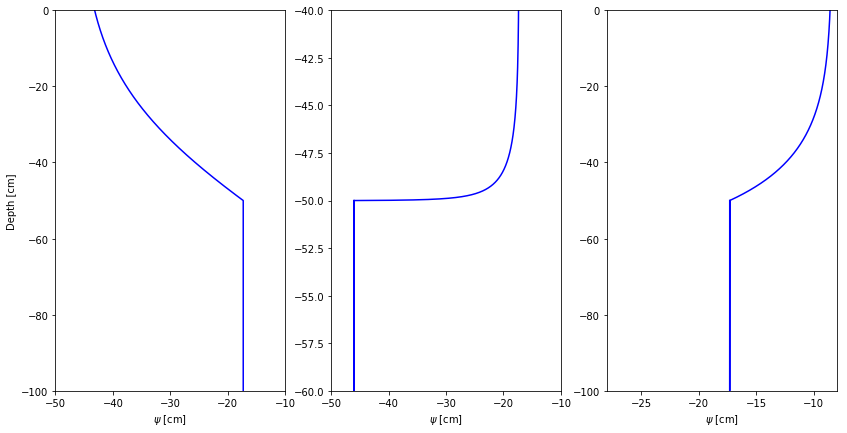

In [49]:
Jw = 0.5;  # constant downward flow rate [cm/d]

# The lower part (constant pressure)
Ks = lambda psi: hydraulic_conductivity(psi,sand)-Jw
Kl = lambda psi: hydraulic_conductivity(psi,loam)-Jw
Kc = lambda psi: hydraulic_conductivity(psi,clay)-Jw
psi_s = optimize.brentq(Ks, -100, 0)
psi_l = optimize.brentq(Kl, -100, 0)
psi_c = optimize.brentq(Kc, -100, 0)

# The upper part
Ks = lambda psi: hydraulic_conductivity(psi,sand)
Kl = lambda psi: hydraulic_conductivity(psi,loam)
Kc = lambda psi: hydraulic_conductivity(psi,clay)
Fs = lambda psi: 1./(Jw/Ks(psi) - 1.) # integrand Eqn [14]
Fl = lambda psi: 1./(Jw/Kl(psi) - 1.)
Fc = lambda psi: 1./(Jw/Kc(psi) - 1.)
    
N = 1000 # resolution
dz = np.ones(N,)
eps = 1.e-5 # to avoid quadrature warnings
    
psi1A = np.linspace(psi_l+eps,psi_s,N) # loam (on sand)
for i in range(0,N):
    dz[i], err = integrate.quad(Fl,psi_s, psi1A[i])
z1A = dz - 50.      
psi1B = np.linspace(psi_l,psi_s-eps,N) # sand (on loam)
for  i in range(0,N):
    dz[i], err = integrate.quad(Fs,psi_l,psi1B[i])
z1B = dz -50;         
psi1C = np.linspace(psi_s,psi_c-eps,N); # clay (on sand)
for  i in range(0,N):    
    dz[i], err = integrate.quad(Fc,psi_s,psi1C[i]) 
z1C = dz -50;

z_ = np.linspace(-50,-100,2) # attach lower const part
z1A = np.hstack((z1A, z_))
psi1A = np.hstack((psi1A, np.array([psi_s,psi_s])))
z1B = np.hstack((z_,z1B))
psi1B = np.hstack((np.array([psi_l,psi_l]), psi1B))
z1C = np.hstack((z_, z1C))
psi1C = np.hstack((np.array([psi_s,psi_s]), psi1C))

# prepare plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 7))    
ax1.plot(psi1A,z1A,'b');
ax1.set_xlabel('$\psi$ [cm]')
ax1.set_ylabel('Depth [cm]')
ax1. set_xlim(-50,-10)
ax1.set_ylim(-100,0)    
ax2.plot(psi1B,z1B,'b');
ax2.set_xlabel('$\psi$ [cm]')
ax2.set_xlim(-50,-10)
ax2.set_ylim(-60,-40)    
ax3.plot(psi1C,z1C,'b');
ax3.set_xlabel('$\psi$ [cm]')
ax3.set_xlim(-28,-8)
ax3.set_ylim(-100,0)
plt.show()

### 2 Steady state evaporation


We consider a loamy soil profile from 0 to -53 cm. Initial condition are $\psi(z,t=0) = -z - 53$ cm ($z$ positive upwards, $z=0$ cm at soil surface, i.e. $\psi(0)=-53$ cm, $\psi(-53) = 0$ cm) 

As boundary conditions we prescribe an eflux of 0.5 cm/day at top and full saturation at the bottom 

The analytical solution is calculated by the following code and reproduces Figure 3 from Vanderborght et al. (2005). 

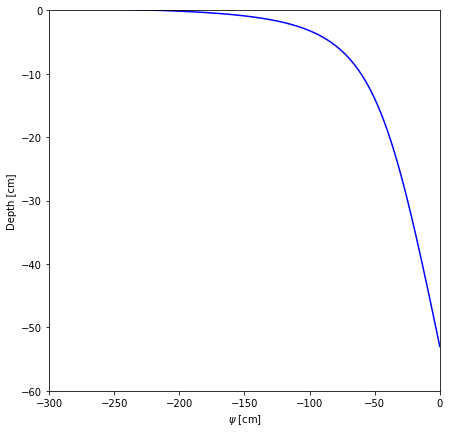

In [50]:
Jw = -0.5 # cm/day

K = lambda psi: hydraulic_conductivity(psi,loam)
F = lambda psi: 1./(Jw/K(psi) - 1.) # Eqn 14

psi2 = np.linspace(0,-300,1000) # psi(-53) = 0
dz = np.zeros(len(psi2),)
for i in range(0, len(psi2)):
    dz[i],err = integrate.quad(F,0,psi2[i])
z2 = dz - 53

fig2 = plt.figure(figsize=(7, 7))
plt.plot(psi2, z2,'b')
plt.xlabel('$\psi$ [cm]')
plt.ylabel('Depth [cm]')
plt.xlim(-300,0)
plt.ylim(-60,0)
plt.show()

## Comparison to numerical solutions

The steady state benchmarks were also evaluated for *Macro*, *Hydrus1D*, *Swap*, *Marthe*, and *Wave* in Vanderborght et al. 2005. 

There are many softwares solving Richards equation. What are the most important features, and which softwares are most suitable for a specific purpose. 

* Availability and license 
* Dimensions: 1D, 1D axial symmetric, 3D
* Mass conservation
* Parallel computing
* Support of unstructured meshes and adaptive refinement


### 1 Steady state flux in a layered soil profile

For an automatic comparison of the numerical results, save the results in a text file with two rows for each subplot (i.e. six rows), containing comma separated depth values (cm) in the first, and pressure head (cm) in the second. Copy the file to folder /soil_water_flow/b1/.

In [56]:
i1 = interp1d(z1A/100, psi1A, kind='linear', fill_value='extrapolate' ) # analytic solution
i2 = interp1d(z1B/100, psi1B, kind='linear', fill_value='extrapolate' ) 
i3 = interp1d(z1C/100, psi1C, kind='linear', fill_value='extrapolate' ) 
interp = [i1,i2,i3]

for dirname, dirnames, filenames in os.walk('soil_water_flow/b1/.)'):
    filenames.sort()
    for i,f in enumerate(filenames):      
        print(f,":\n")        
        data = np.loadtxt(f,delimiter=',')        
        fig, ax = plt.subplots(1, 3, figsize=(14, 7))       
        
        for j in range(0,3):
            z = data[2*j, :]
            psi = data[2*j+1, :]        
            psi_a = interp[j](sorted(z))
            
            ax[j].plot(psi_a,sorted(z),'b') # analytical solution
            ax[j].plot(psi,z,'r*') # numeric solution
            ax[j].set_xlabel("$\Psi$ [cm])")
            ax[j].set_ylabel("Depth [cm]")
                       
            n = len(z)  # calculate R^2
            r = 1 - ( np.sum(np.square(psi_a-psi)) / (np.sum(np.square(psi_a))-np.square(np.sum(psi_a))/n) )    
            print("R² =", r ,"( N =", n, ")\n")
            
        plt.title(f)                           
        plt.show()

hello


### 2 Steady state evaporation

For an automatic comparison of the numerical results, save the results in a text file with two rows containing comma separated depth values (cm) in the first, and pressure head (cm) in the second. Copy the fileto the folder /soil_water_flow/b2/.

In [52]:
interp = interp1d(z2/100, psi2, kind='linear', fill_value='extrapolate' ) # analytic solution

for dirname, dirnames, filenames in os.walk('soil_water_flow/b2'):
    filenames.sort()
    for i,f in enumerate(filenames):      

        print(f,":\n")
        
        data = np.loadtxt(f,delimiter=',')        
        z = data[0, :]
        psi = data[1, :]        
        psi_a = interp(z)

        fig = plt.figure(figsize=(7, 7))      
                    
        plt.plot(psi_a,z,'b') # analytical solution
        plt.plot(psi,z,'r*') # numeric solution
        plt.xlabel("$\Psi$ [cm]")
        plt.ylabel("Depth [cm]")
                        
        n = len(z) # calculate R^2
        r = 1 - ( np.sum(np.square(psi_a-psi)) / (np.sum(np.square(psi_a))-np.square(np.sum(psi_a))/n) )    
        print("R² =", r ,"( N =", n, ")\n")

            
        plt.title(f)                           
        plt.show()

## References

Vanderborght, J and Kasteel, R and Herbst, M and Javaux, M and Thiery, D and Vanclooster, M and Mouvet, C and Vereecken, H (2005) A set of analytical benchmarks to test numerical models of flow and transport in soils. *Vadose Zone Journal*, 4(1):206-221

Van Genuchten, MT (1980) Closed-form equation for predicting the hydraulic conductivity of unsaturated soils. *Soil Science Society of America Journal* 44(5):892-898
